## Determine the Distance and % Overlap Between Annotated Images


In [34]:
# Import libraries and query Aletheia for all annotated images

import time
import numpy as np
import pandas as pd
from datetime import datetime as dt
from brtdevkit.core.db import DBConnector, DatetimeFilter
from matplotlib import pyplot as plt, rcParams
from geopy import distance

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. Written by Andrei P.
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

# Convert between meters and inches
def in2m(in_val): # inches to meters
    return in_val * 0.0254

def m2in(m_val): # meters to inches
    return m_val / 0.0254

# Set start date for query
start = dt(2020, 3,7)

# DCMs
dcms = ['DCM-MANATEE', 'DCM-WALRUS', 'DCM-SEAL', 'DCM-OTTER', 'DCM-PORPOISE', 'DCM-DOLPHIN']
#'robot_name':{"$in":dcms}
# Select all annotated images past the start date
filters = {"artifacts.kind": "nrg", 
           "crop_name": {"$in": ['CORN', 'COTTON', 'SOYBEANS']}, 
           "has_human_annotation": True, 
           
          }

full_df, elapsed_time = get_shasta_data(filters=filters, start=start)
full_df['date_collected'] = pd.to_datetime(full_df['collected_on'].dt.date)
print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")

2020-07-30 10:30:30,104 - APIRequestor - ERROR - API Authentication failed. rcode: 401, message: b'{"message":"Invalid OAuth access token"}\n'
2020-07-30 10:30:30,105 - APIRequestor - INFO - API access token expired. Refreshing tokens now.


Queried 94359 images in 156.86 s.


In [35]:
# Look at two example images

qdf = full_df.copy()
qdf.sort_values('collected_on', ascending=False)
l =61001

img1 = qdf.iloc[l]
img2 = qdf.iloc[l+1]

first_lat_long = [img1['latitude'], img1['longitude']]
last_lat_long = [img2['latitude'], img2['longitude']]
dist_travelled = distance.distance(first_lat_long, last_lat_long).meters

print((qdf.iloc[l][['camera_height','row_spacing']]))
print(dist_travelled)
print(qdf.iloc[l]['_id'])
print(qdf.iloc[l+1]['_id'])

camera_height        1.524
row_spacing      INCHES_30
Name: 5ee3bcc34d2389d34d064717, dtype: object
0.8052782837572123
5ee3bcc34d2389d34d064717
5ee3bcc34d2389d34d064721


In [38]:
# Create dataframe of relevant features for all annotated images

qdf = full_df.copy()

# Set Date Filter if Desired
qdf = qdf[qdf['date_collected'] > '2020-03-07']

# This could probably be vectorized better to speed it up a bit
ds = []
ns = []
wk = []
dcms = []
cht = []
fields = []
dc = qdf['robot_name'].unique()


for d in dc:
    ddf = qdf[qdf['robot_name']==d]
    for o in ddf['operating_field_name'].unique():
        op = ddf[ddf['operating_field_name']== o]
        op = op.sort_values('collected_on')
        features = [d.get('coordinates') for d in op.gnss]
        dst = 0
        for n in range(1,len(op)-1):
            first_lat_long = [features[n-1][1], features[n-1][0]]
            last_lat_long = [features[n][1], features[n][0]]
            dist_travelled = distance.distance(first_lat_long, last_lat_long).meters
            if (dist_travelled < 3):
                ds.append(dist_travelled)
                wk.append(op.date_collected[0].week)
                cht.append(op.camera_height[n])
                fields.append(o)
                dcms.append(d)
                ns.append(len(op))

annotation_distances = pd.DataFrame({'dcm_name':dcms, 'week':wk, 'camera_height':cht, 'operating_field_name':fields, 'n_images_collected':ns, 'distance_covered':ds})
print(f'{((len(annotation_distances[annotation_distances.camera_height.isna()])/len(annotation_distances))*100):.2f}% of images have NaN camera_height')
annotation_distances.head()

0.00% of images have NaN camera_height


,dcm_name,week,camera_height,operating_field_name,n_images_collected,distance_covered
0,DCM-DOLPHIN,13,1.42,barton west 1,283,0.966575
1,DCM-DOLPHIN,13,1.42,barton west 1,283,1.116820
2,DCM-DOLPHIN,13,1.42,barton west 1,283,0.966575
3,DCM-DOLPHIN,13,1.42,barton west 1,283,0.966575
4,DCM-DOLPHIN,13,1.42,barton west 1,283,0.634392


The median distance between annotated images is 0.85 meters


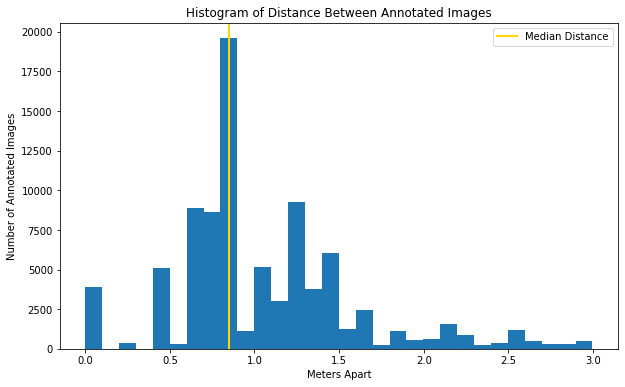

In [39]:
# Plot histogram of distance between annotated images

med_dist = annotation_distances.distance_covered.median()
print(f'The median distance between annotated images is {med_dist:.2f} meters')

plt.figure(figsize=(10,6))
plt.title('Histogram of Distance Between Annotated Images')
plt.hist(annotation_distances['distance_covered'], bins=30)
plt.xlabel('Meters Apart')
plt.ylabel('Number of Annotated Images')
plt.axvline(med_dist, linewidth=2, color = 'gold')
plt.legend(['Median Distance'])
plt.savefig('annotation_distances.png')
plt.show()

In [17]:
# Calculate distance seen in an image

def calc_distance(z, theta, fov_v):
    """
    Calculate the linear distance covered in an image.
    """
    xmin = z * np.tan(theta - (fov_v / 2.0))
    xmax = z * np.tan(theta + (fov_v / 2.0))
    return xmin, xmax

fov_v = np.radians(48)
z = in2m(40)
theta = np.radians(28)

dist_covered = calc_distance(z, theta,fov_v)[1]-calc_distance(z, theta,fov_v)[0]
dist_covered

1.2293750573735616

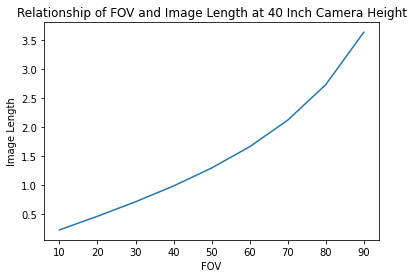

In [42]:
fovs = np.linspace(10, 90, 9)
sizes = []
for i in fovs:
    z = in2m(40)
    theta = np.radians(28)
    dist_covered = calc_distance(z, theta,np.radians(i))[1]-calc_distance(z, theta,np.radians(i))[0]
    sizes.append(dist_covered)
plt.plot(fovs, sizes)
plt.title('Relationship of FOV and Image Length at 40 Inch Camera Height')
plt.xlabel('FOV')
plt.ylabel('Image Length')
plt.savefig('FOV.png')
plt.show() 

The mean image length is 1.513 meters


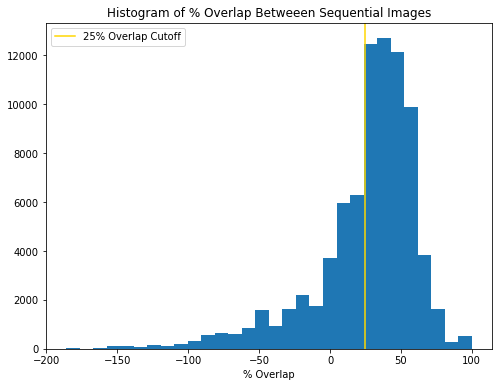

Median image overlap is 33.5%
36.24% of annotated images have less than 25% overlap
16.18% of annotated images have 0% overlap


In [44]:
# Calculate length of ground covered in an image from camera height and fixed angles of camera

fov_v = np.radians(45.7)
theta = np.radians(28)

annotation_distances['image_length'] = calc_distance((annotation_distances['camera_height']), theta,fov_v)[1]-calc_distance((annotation_distances['camera_height']), theta,fov_v)[0]
print(f'The mean image length is {np.mean(annotation_distances.image_length):.3f} meters')

# Remove the few NaNs and extreme outliers
annotation_distances = annotation_distances[(annotation_distances.image_length >0)&(annotation_distances.image_length <3)]

# Calculate % Overlap between images
annotation_distances['overlap'] = ((annotation_distances['image_length']-annotation_distances['distance_covered'])/annotation_distances['image_length'])*100

plt.figure(figsize=(8,6))
plt.title('Histogram of % Overlap Betweeen Sequential Images')
plt.hist(annotation_distances['overlap'], bins=30)
plt.axvline(25, color='gold')
plt.xlabel('% Overlap')
plt.legend(['25% Overlap Cutoff'])
plt.savefig('Overlap.png')
plt.show()

print(f'Median image overlap is {np.median(annotation_distances.overlap):.1f}%')
print(f'{((len(annotation_distances[annotation_distances.overlap<=25])/len(annotation_distances))*100):.2f}% of annotated images have less than 25% overlap')
print(f'{((len(annotation_distances[annotation_distances.overlap<=0])/len(annotation_distances))*100):.2f}% of annotated images have 0% overlap')

In [28]:
# Calculate median distance and 5 overlap covered by individual DCMs and machines

machines = annotation_distances.groupby('dcm_name').median().sort_values('distance_covered')
machines[machines['distance_covered']>0][['distance_covered', 'overlap']]

,distance_covered,overlap
dcm_name,,
DCM-MANATEE,0.843023,40.066880
DCM-DOLPHIN,1.023553,34.315068
DCM-SEAL,1.076612,29.801382
DCM-WALRUS,1.200729,29.726308
DCM-OTTER,1.271039,24.552379


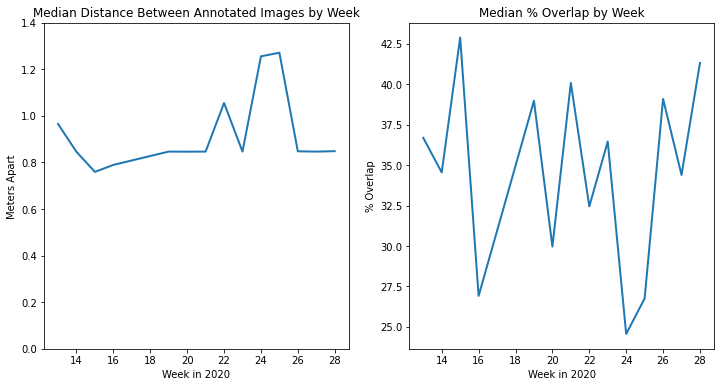

In [45]:
# plot distance by week of the year

week_dist = annotation_distances.groupby('week').median()

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(week_dist['distance_covered'], linewidth=2)
plt.title('Median Distance Between Annotated Images by Week')
plt.ylabel('Meters Apart')
plt.ylim(0, 1.4)
plt.xlabel('Week in 2020')
plt.subplot(122)
plt.plot(week_dist['overlap'], linewidth=2)
plt.title('Median % Overlap by Week')
plt.ylabel('% Overlap')
plt.xlabel('Week in 2020')
#plt.savefig('annotations.png')
plt.show()

In [140]:
# Identify identical lat/longs and display how many images share them

qdf = full_df.copy()
qdf['lat_lon'] = qdf.apply(lambda x: (x['latitude'], x['longitude']), axis=1)
ident = qdf['lat_lon'].value_counts().sort_values()

# Display coordinates of images with >=10 identical lat/longs
more_than_ten = ident[ident>=10]
more_than_ten

(35.39858627319336, -91.2569351196289)        10
(41.989810943603516, -93.63055419921875)      11
(35.67251968383789, -90.19538879394531)       12
(35.5079345703125, -91.2315902709961)         12
(35.67459487915039, -90.19597625732422)       12
(35.39949035644531, -91.25665283203125)       12
(41.9900016784668, -93.6307144165039)         14
(35.673828125, -90.19599914550781)            15
(35.671077728271484, -90.19627380371094)      16
(35.64690399169922, -90.21665954589844)       16
(35.39856719970703, -91.2569351196289)        17
(35.67460250854492, -90.19597625732422)       17
(35.64690399169922, -90.21659851074219)       18
(35.398536682128906, -91.2569351196289)       18
(35.39851760864258, -91.2569351196289)        18
(33.31668472290039, -91.12471771240234)       20
(35.399723052978516, -91.25665283203125)      20
(32.472408294677734, -91.87535858154297)      23
(33.31668472290039, -91.12471008300781)       24
(35.67460632324219, -90.19597625732422)       29
(35.672950744628906,

In [141]:
# For the above list of identical lat/longs display how many came from each machine

m =[]
for i, j in more_than_ten.index:
    m.append(qdf[(qdf['latitude']==i)&(qdf['longitude']==j)].robot_name.unique())
machines = pd.Series(m)
machines.value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[SHASTA-FB-BRADLEY]    29
[BLACKBIRD]            10
[DCM-MANATEE]           3
[SHASTA-FB-PALADIN]     2
[ATM-DUCKDUCK]          2
[DCM-DOLPHIN]           1
[SHASTA-MULE]           1
dtype: int64

Queried 756 images in 40.53 s.
The Unique Camera Heights From this Field Were: [1.01600003 1.26999998 1.52400005].
This Line Should be Straight Without Large Jumps. If otherwise something is wrong with the calculation


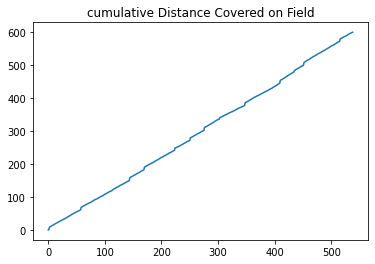

Total distance covered was 599.3 meters on the setion 5 field
There were 756 images collected from the setion 5 field.
The average distance between images on the setion 5 field was 1.26 meters.


In [143]:
# Examine Image Distances From a Single Field
# Used as a quality control step to examine anomalies
# Requires a seperate query to include non-annotated images

# set field name to be examined
ofn =  'setion 5'

# Query Aletheia
filters = {"artifacts.kind": "nrg", 
           'operating_field_name': ofn
          }

qdf, elapsed_time = get_shasta_data(filters=filters, start=start)
qdf['date_collected'] = pd.to_datetime(qdf['collected_on'].dt.date)
print(f"Queried {len(qdf)} images in {elapsed_time:.2f} s.")

op = qdf[qdf['operating_field_name']== ofn]
print(f'The Unique Camera Heights From this Field Were: {op.camera_height.unique()}.')
features = [d.get('coordinates') for d in op.gnss]
dst = 0
ds = []

for n in range(1,len(op)-1):
    first_lat_long = [features[n-1][1], features[n-1][0]]
    last_lat_long = [features[n][1], features[n][0]]
    dist_travelled = distance.distance(first_lat_long, last_lat_long).meters
    if (dist_travelled < 10) and (dist_travelled > 0):
        ds.append(dst)
        dst+=(dist_travelled)

print(f'This Line Should be Straight Without Large Jumps. If otherwise something is wrong with the calculation')
plt.plot(ds)
plt.title('cumulative Distance Covered on Field')
plt.show()

print(f'Total distance covered was {dst:.1f} meters on the {ofn} field')
print(f'There were {len(op)} images collected from the {ofn} field.')
print(f'The average distance between images on the {ofn} field was {(len(op)/dst):.2f} meters.')